# Experimento 2

Modificação do Experimento 1 para induzir interferência mútua entre os dois primeiros nós próximos ao sink, de modo que o nó 2 interfira no nó 6 e vice-versa.

In [3]:
import sys
import os
import json

# Adiciona o diretório base ao sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../../.."))  # Ajuste conforme a localização do notebook
if project_path not in sys.path:
    sys.path.insert(0, project_path)
    
def json_to_exp_dict(json_path: str) -> dict:
    """
    Lê um arquivo JSON contendo uma simulação e converte para o dicionário exp.
    
    Args:
        json_path: Caminho para o arquivo JSON.
        
    Returns:
        Um dicionário no formato especificado.
    """
    with open(json_path, 'r') as file:
        data = json.load(file)

    sim_model = data["simulationModel"]
    fixed_motes = sim_model["simulationElements"]["fixedMotes"]

    points = [tuple(mote["position"]) for mote in fixed_motes]

    exp = {
        "points": points,
        "region": tuple(sim_model["region"]),
        "radius": sim_model["radiusOfReach"],
        "interf": sim_model["radiusOfInter"]
    }

    return exp


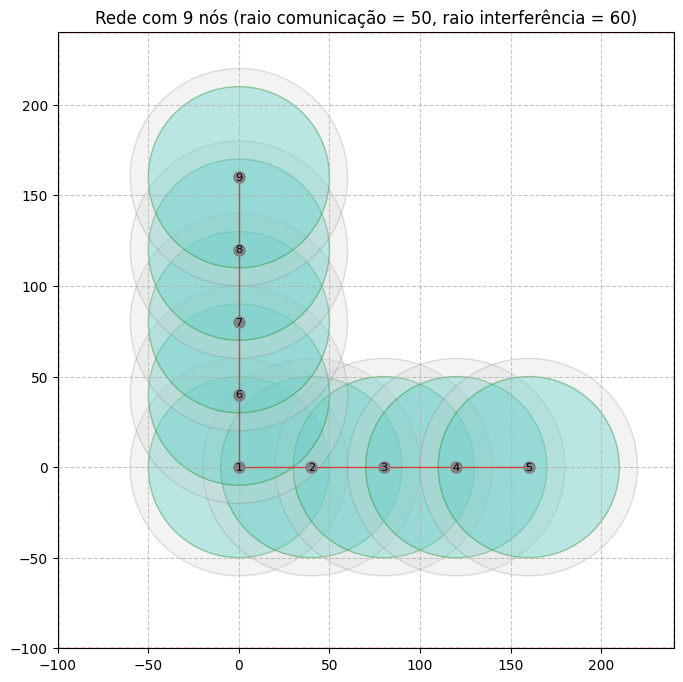

In [4]:
from pylib import visual

exp = json_to_exp_dict("inputExample.json")
visual.plot_network(exp["points"], exp["region"], exp["radius"], exp["interf"])

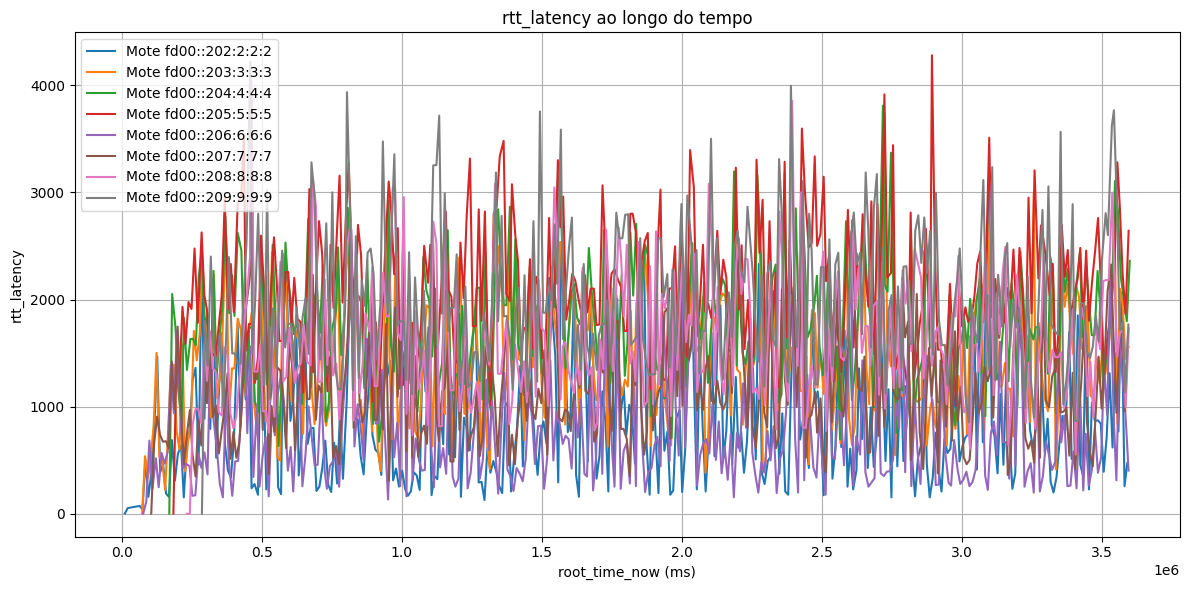

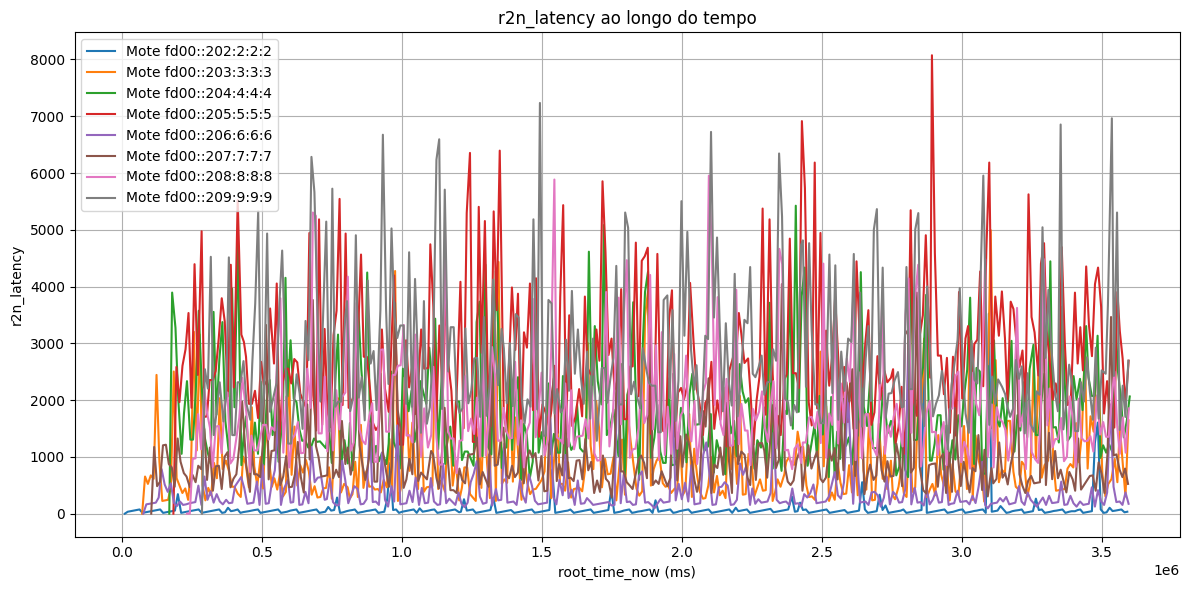

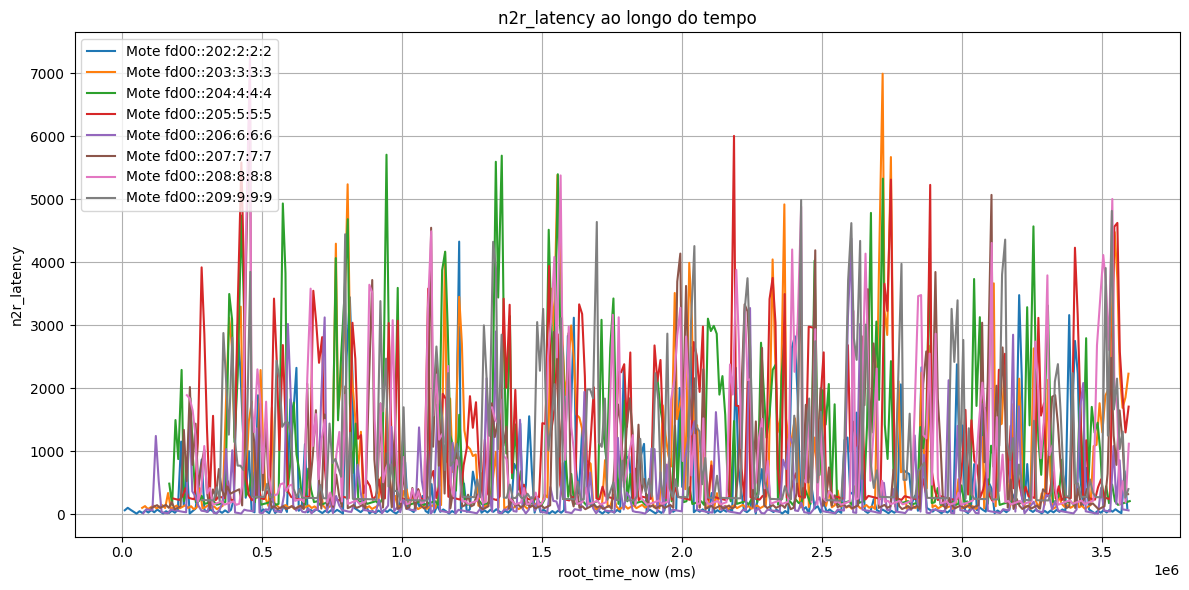

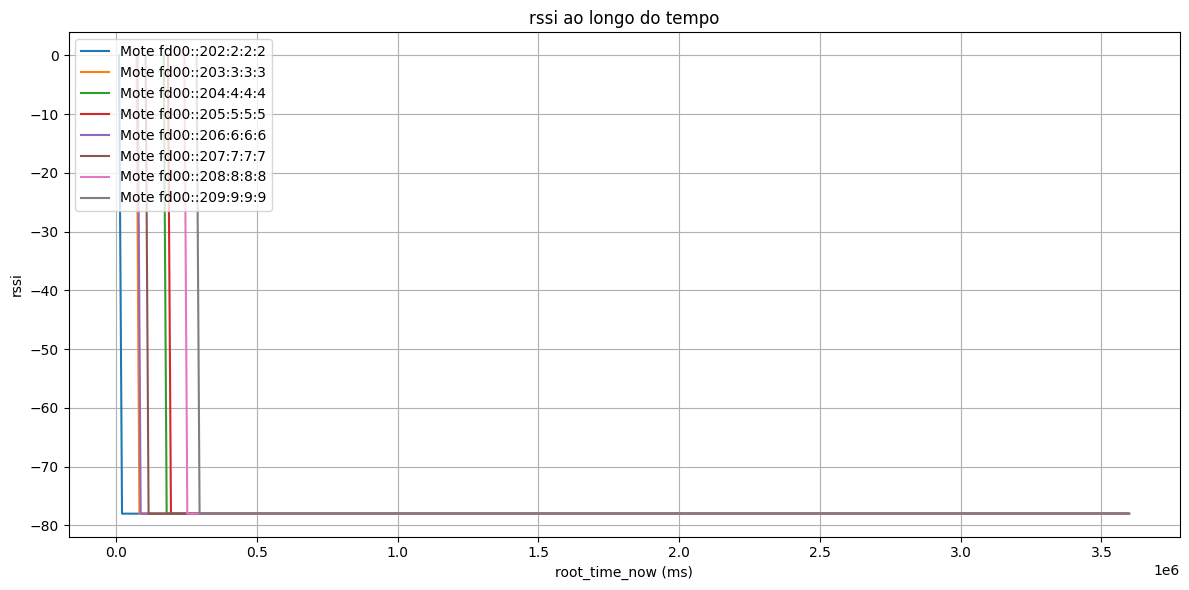

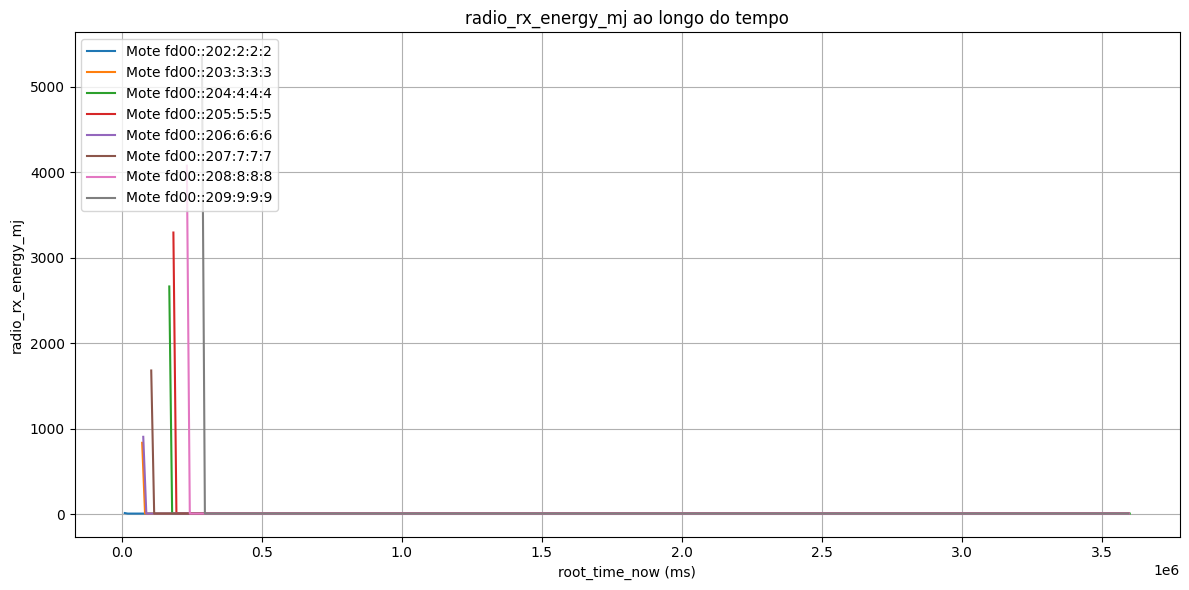

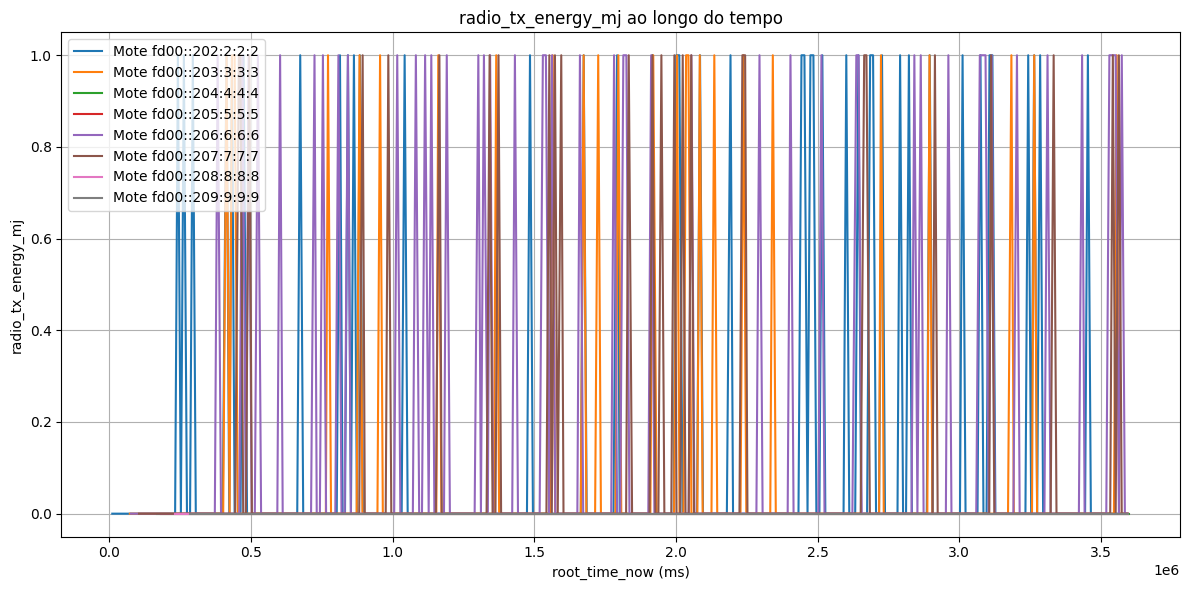

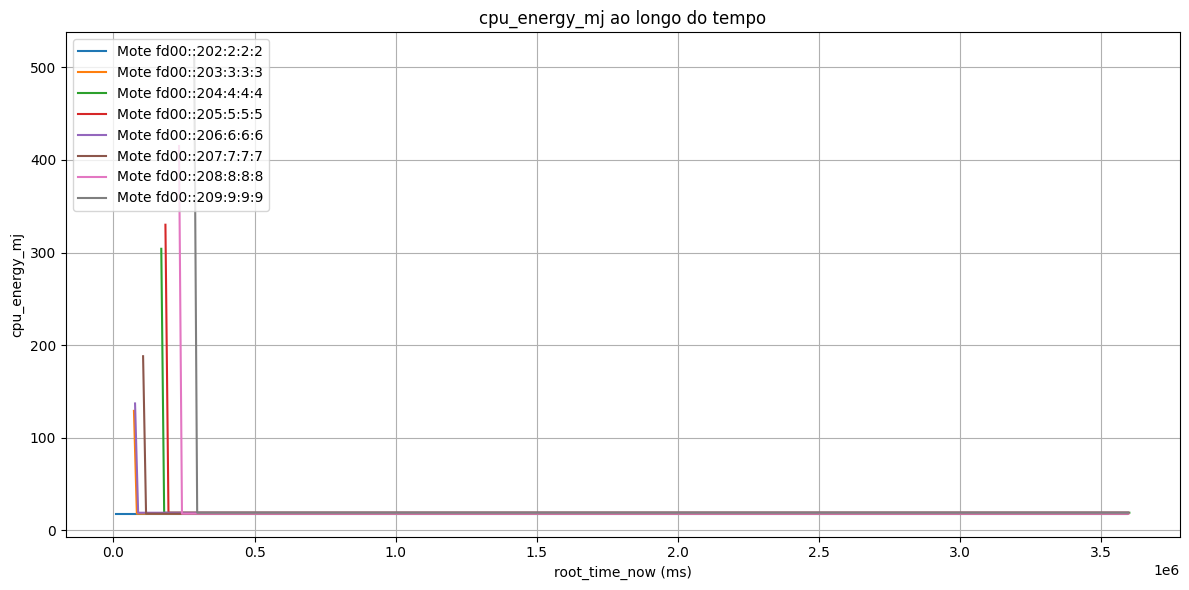

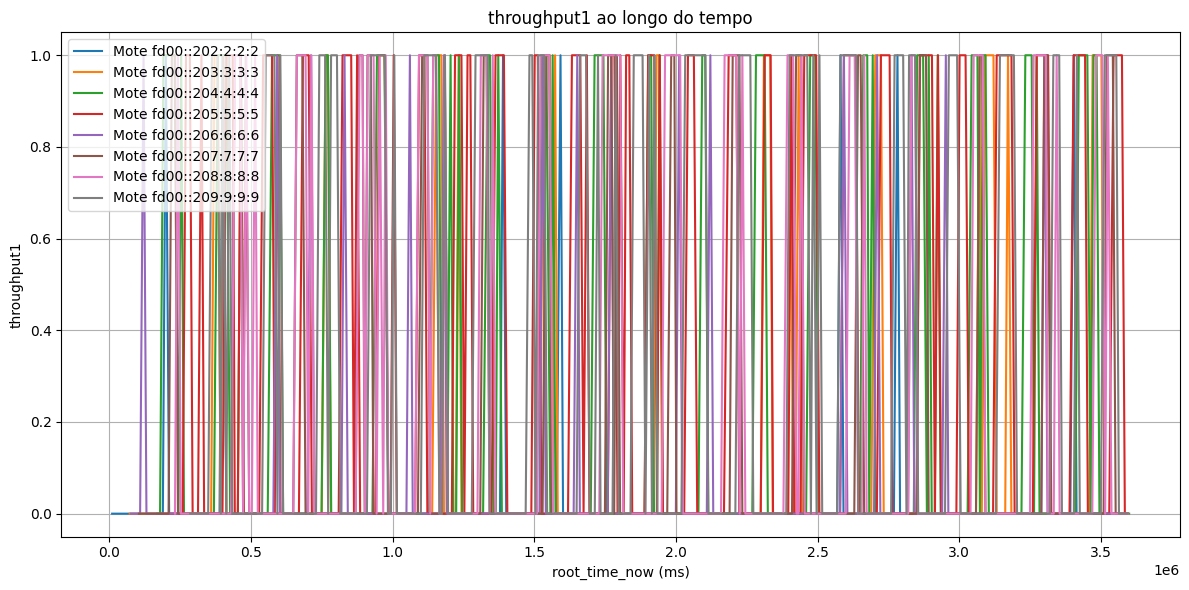

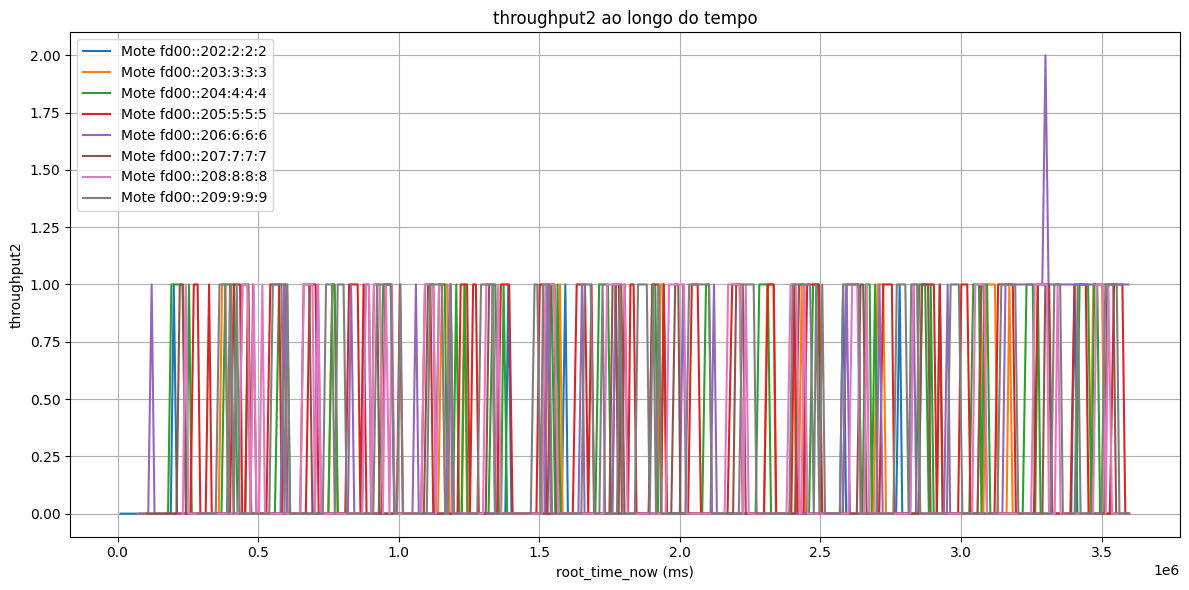

In [5]:
import json
import re
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Caminho do arquivo de log
log_path = Path("./cooja.log")

# Regex para extrair JSONs e o timestamp correspondente
json_pattern = re.compile(r'\[Mote:1\].*?(\{.*?\})')

data = []
current_time = 0

with log_path.open("r", encoding="utf-8") as f:
    for line in f:
        match = json_pattern.search(line)
        if match:
            json_str = match.group(1)
            try:
                json_data = json.loads(json_str)
                json_data["throughput1"] = json_data["server_sent"] - json_data["total_received"]
                json_data["throughput2"] = json_data["server_sent"] + json_data["total_sent"] - json_data["server_received"]
                data.append(json_data)
            except json.JSONDecodeError:
                continue

# Converter para DataFrame
df = pd.DataFrame(data)

# Ordenar para facilitar visualização
df.sort_values(by=["node", "root_time_now"], inplace=True)

df.to_csv("cooja_metrics.csv", index=False)

# Listar métricas disponíveis para visualização
metrics_to_plot = [
    "rtt_latency", 
    "r2n_latency",
    "n2r_latency",
    "rssi", 
    "radio_rx_energy_mj", 
    "radio_tx_energy_mj", 
    "cpu_energy_mj",
    "throughput1",
    "throughput2"
    ]

# Plotar as métricas ao longo do tempo para cada mote
unique_motes = df["node"].unique()

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    for mote in unique_motes:
        mote_df = df[df["node"] == mote]
        plt.plot(mote_df["root_time_now"], mote_df[metric], label=f"Mote {mote}")
    plt.title(f"{metric} ao longo do tempo")
    plt.xlabel("root_time_now (ms)")
    plt.ylabel(metric)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
